# Part 1: Implement a web crawler to capture top250 movie from douban.com


# 1.数据收集

In [4]:
import urllib.request as urlrequest
from bs4 import BeautifulSoup

top250_url = "https://movie.douban.com/top250?start={}&filter="

with open('top250_f1.csv','w',encoding='utf8') as outputfile: 
    outputfile.write("num#title#director#role#init_year#area#genre#rating_num#comment_num#comment#url\n") 
    for i in range(10):
        start = i*25
        url_visit = top250_url.format(start)
        crawl_content = urlrequest.urlopen(url_visit).read()
        http_content = crawl_content.decode('utf8')   
        soup = BeautifulSoup(http_content,'html.parser')        
        all_item_divs = soup.find_all(class_='item')

        for each_item_div in all_item_divs:
            pic_div = each_item_div.find(class_='pic')
            num = pic_div.find('em').get_text()   #排名
            href = pic_div.find('a')['href']      #电影链接
            title = pic_div.find('img')['alt']    #电影名称
            bd_div = each_item_div.find(class_='bd')
            infos = bd_div.find('p').get_text().strip().split('\n')        
            infos_1 = infos[0].split('\xa0\xa0\xa0')
            director = infos_1[0][4:].rstrip('...').rstrip('/').split('/')[0]   #导演
            role = str(infos_1[1:])[6:].split('/')[0]                           #主演
            infos_2 = infos[1].lstrip().split('\xa0/\xa0')
            year = infos_2[0]    #上映时间
            area = infos_2[1]    #国家/地区
            genre = infos_2[2:]  #电影类型
            star_div = each_item_div.find(class_='star')
            rating_num = star_div.find(class_='rating_num').get_text()      #评分
            comment_num = star_div.find_all('span')[3].get_text()[:-3]      #评价数量
            quote = each_item_div.find(class_='quote')
            inq = quote.find(class_='inq').get_text()  #一句话评价

            outputfile.write('{}#{}#{}#{}#{}#{}#{}#{}#{}#{}#{}\n'.format(num,title,director,role,year,area,
                                                                         genre,rating_num,comment_num,inq,href)) 

In [21]:
#preview
import numpy as ny
import pandas as pd
df_1 = pd.read_csv("top250_f1.csv",sep = "#", encoding = 'utf8')
df_1.head()

,num,title,director,role,init_year,area,genre,rating_num,comment_num,comment,url
0,1,肖申克的救赎,弗兰克·德拉邦特 Frank Darabont,蒂姆·罗宾斯 Tim Robbins,1994,美国,['犯罪 剧情'],9.6,1123064,希望让人自由。,https://movie.douban.com/subject/1292052/
1,2,霸王别姬,陈凯歌 Kaige Chen,张国荣 Leslie Cheung,1993,中国大陆 香港,['剧情 爱情 同性'],9.5,819152,风华绝代。,https://movie.douban.com/subject/1291546/
2,3,这个杀手不太冷,吕克·贝松 Luc Besson,让·雷诺 Jean Reno,1994,法国,['剧情 动作 犯罪'],9.4,1040425,怪蜀黍和小萝莉不得不说的故事。,https://movie.douban.com/subject/1295644/
3,4,阿甘正传,Robert Zemeckis,Tom Hanks,1994,美国,['剧情 爱情'],9.4,887148,一部美国近现代史。,https://movie.douban.com/subject/1292720/
4,5,美丽人生,罗伯托·贝尼尼 Roberto Benigni,罗伯托·贝尼尼 Roberto Beni...'],1997,意大利,['剧情 喜剧 爱情 战争'],9.5,517743,最美的谎言。,https://movie.douban.com/subject/1292063/


# 2.进一步深入每个页面去收集一下各个电影的细节

In [26]:
import urllib
import urllib.request as urlrequest
import json
import time
import random
import pandas as pd

df = pd.read_csv("top250_f1.csv",sep = "#", encoding = 'utf8')
urlsplit = df.url.str.split('/').apply(pd.Series)
id_list = list(urlsplit[4])
num=0
# IP_list = [  ]  #这里写几个可用的IP地址和端口号，只抓250个页面，有两三个IP就够了。
# IP = random.chioce(IP_list)

with open('top250_f2.csv', 'w',encoding='utf8') as outputfile:    

    outputfile.write("num#rank#alt_title#title#pubdate#language#writer#director#cast#movie_duration#year#movie_type#tags#image\n")

#     proxy = urlrequest.ProxyHandler({'https':  'IP'})
#     opener = urlrequest.build_opener(proxy)
#     opener.addheaders = [('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/603.1.30 (KHTML, like Gecko) Version/10.1 Safari/603.1.30')]                      
#     urlrequest.install_opener(opener)

    for id in id_list:       
        url_visit = 'https://api.douban.com/v2/movie/{}'.format(id)       
        crawl_content = urlrequest.urlopen(url_visit).read()        
        json_content = json.loads(crawl_content.decode('utf-8'))

        rank = json_content['rating']['average']
        alt_title = json_content['alt_title']
        image = json_content['image']
        title = json_content['title']        
        pubdate = json_content['attrs']['pubdate']
        language = json_content['attrs']['language']
        try:
            writer = json_content['attrs']['writer']
        except:
            writer = 'None'
        director = json_content['attrs']['director']
        cast = json_content['attrs']['cast']
        movie_duration = json_content['attrs']['movie_duration']
        year = json_content['attrs']['year']
        movie_type = json_content['attrs']['movie_type']
        tags = json_content['tags']
        num = num +1    
        outputfile.write("{}#{}#{}#{}#{}#{}#{}#{}#{}#{}#{}#{}#{}#{}\n".format(num,rank,alt_title,title,pubdate,language,writer,
                                                                              director,cast,movie_duration,year,movie_type,tags,image))
        time.sleep(1)

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [11]:

df_2 = pd.read_csv("top250_f2.csv",sep = "#", encoding = 'utf8')
df_2.head()


,num,rank,alt_title,title,pubdate,language,writer,director,cast,movie_duration,year,movie_type,tags,image
0,1,9.6,肖申克的救赎 / 月黑高飞(港),The Shawshank Redemption,"['1994-09-10(多伦多电影节)', '1994-10-14(美国)']",['英语'],"['弗兰克·德拉邦特 Frank Darabont', '斯蒂芬·金 Stephen King']",['弗兰克·德拉邦特 Frank Darabont'],"['蒂姆·罗宾斯 Tim Robbins', '摩根·弗里曼 Morgan Freeman'...",['142分钟'],['1994'],"['犯罪', '剧情']","[{'count': 224697, 'name': '经典'}, {'count': 19...",https://img3.doubanio.com/view/photo/s_ratio_p...
1,2,9.5,再见，我的妾,霸王别姬,['1993-01-01(香港)'],['汉语普通话'],"['芦苇 Wei Lu', '李碧华 Lillian Lee']",['陈凯歌 Kaige Chen'],"['张国荣 Leslie Cheung', '张丰毅 Fengyi Zhang', '巩俐 ...",['171 分钟'],['1993'],"['剧情', '爱情', '同性']","[{'count': 143389, 'name': '经典'}, {'count': 71...",https://img3.doubanio.com/view/photo/s_ratio_p...
2,3,9.4,这个杀手不太冷 / 杀手莱昂,Léon,['1994-09-14(法国)'],"['英语', '意大利语', '法语']",['吕克·贝松 Luc Besson'],['吕克·贝松 Luc Besson'],"['让·雷诺 Jean Reno', '娜塔莉·波特曼 Natalie Portman', ...","['110分钟(剧场版)', '133分钟(国际版)']",['1994'],"['剧情', '动作', '犯罪']","[{'count': 166951, 'name': '经典'}, {'count': 10...",https://img3.doubanio.com/view/photo/s_ratio_p...
3,4,9.4,阿甘正传 / 福雷斯特·冈普,Forrest Gump,"['1994-06-23(洛杉矶首映)', '1994-07-06(美国)']",['英语'],"['Eric Roth', 'Winston Groom']",['Robert Zemeckis'],"['Tom Hanks', 'Robin Wright Penn', 'Gary Sinis...",['142 分钟'],['1994'],"['剧情', '爱情']","[{'count': 198682, 'name': '励志'}, {'count': 14...",https://img1.doubanio.com/view/photo/s_ratio_p...
4,5,9.5,美丽人生 / 一个快乐的传说(港),La vita è bella,['1997-12-20(意大利)'],"['意大利语', '德语', '英语']","['文森佐·克拉米 Vincenzo Cerami', '罗伯托·贝尼尼 Roberto B...",['罗伯托·贝尼尼 Roberto Benigni'],"['罗伯托·贝尼尼 Roberto Benigni', '尼可莱塔·布拉斯基 Nicolet...","['116分钟', '125分钟(加长版)']",['1997'],"['剧情', '喜剧', '爱情', '战争']","[{'count': 75756, 'name': '意大利'}, {'count': 75...",https://img3.doubanio.com/view/photo/s_ratio_p...


# 3. Data Cleaning

In [27]:
#check duplicated or not
df.duplicated().value_counts()
print(len(df.title.unique()))
print(len(df.num.unique()))

250
250


In [44]:
#delete useless delimiter
df['genre'] = df['genre'].str[2:-2]
df.head()

,num,title,director,role,init_year,area,genre,rating_num,comment_num,comment,url
0,1,肖申克的救赎,弗兰克·德拉邦特 Frank Darabont,蒂姆·罗宾斯 Tim Robbins,1994,美国,,9.6,1123064,希望让人自由。,https://movie.douban.com/subject/1292052/
1,2,霸王别姬,陈凯歌 Kaige Chen,张国荣 Leslie Cheung,1993,中国大陆 香港,爱情,9.5,819152,风华绝代。,https://movie.douban.com/subject/1291546/
2,3,这个杀手不太冷,吕克·贝松 Luc Besson,让·雷诺 Jean Reno,1994,法国,动作,9.4,1040425,怪蜀黍和小萝莉不得不说的故事。,https://movie.douban.com/subject/1295644/
3,4,阿甘正传,Robert Zemeckis,Tom Hanks,1994,美国,,9.4,887148,一部美国近现代史。,https://movie.douban.com/subject/1292720/
4,5,美丽人生,罗伯托·贝尼尼 Roberto Benigni,罗伯托·贝尼尼 Roberto Beni...'],1997,意大利,喜剧 爱情,9.5,517743,最美的谎言。,https://movie.douban.com/subject/1292063/


In [29]:
# split mulitple areas
area_split = df['area'].str.split(' ').apply(pd.Series)
area_split.head()
a = area_split.apply(pd.value_counts).fillna('0') 
a.columns = ['area_1','area_2','area_3','area_4','area_5']
a['area_1'] = a['area_1'].astype(int)
a['area_2'] = a['area_2'].astype(int)
a['area_3'] = a['area_3'].astype(int)
a['area_4'] = a['area_4'].astype(int)
a['area_5'] = a['area_5'].astype(int)
a = a.apply(lambda x: x.sum(),axis = 1)
area_c = pd.DataFrame(a, columns = ['counts'])
area_c.head()

,counts
中国大陆,16
丹麦,1
伊朗,2
冰岛,1
加拿大,7


In [30]:
genre_split = df['genre'].str.split(' ').apply(pd.Series)
genre_split.head()
g = genre_split.apply(pd.value_counts)
g.head(6)
g = g.unstack().dropna().reset_index()
g.head()

,level_0,level_1,0
0,0,传记,2.0
1,0,儿童,1.0
2,0,冒险,6.0
3,0,剧情,164.0
4,0,动作,14.0


In [31]:
director_split = df['director'].str.replace('\', \'','#').str.split('#').apply(pd.Series)
director_split.head()


,0
0,弗兰克·德拉邦特 Frank Darabont
1,陈凯歌 Kaige Chen
2,吕克·贝松 Luc Besson
3,Robert Zemeckis
4,罗伯托·贝尼尼 Roberto Benigni


In [32]:
cast_split = df['role'].str.replace('\', \'','#').str.split('#').apply(pd.Series)  #[[0,1,2,3]].columns=['performer_1','performer_2','performer_3','performer_4']
cast_split.head()

,0
0,蒂姆·罗宾斯 Tim Robbins
1,张国荣 Leslie Cheung
2,让·雷诺 Jean Reno
3,Tom Hanks
4,罗伯托·贝尼尼 Roberto Beni...']


In [33]:
df.describe()

,num,rating_num,comment_num
count,250.000000,250.000000,2.500000e+02
mean,125.500000,8.801200,2.972235e+05
std,72.312977,0.266388,1.833526e+05
min,1.000000,8.300000,5.002000e+04
25%,63.250000,8.600000,1.663665e+05
50%,125.500000,8.800000,2.569615e+05
75%,187.750000,9.000000,3.749822e+05
max,250.000000,9.600000,1.123064e+06


In [34]:
df[['num','title']].head(10)

,num,title
0,1,肖申克的救赎
1,2,霸王别姬
2,3,这个杀手不太冷
3,4,阿甘正传
4,5,美丽人生
5,6,泰坦尼克号
6,7,千与千寻
7,8,辛德勒的名单
8,9,盗梦空间
9,10,机器人总动员


In [35]:
Top10_rating_num = df[['rating_num','title']].sort_values(by = ['rating_num'],ascending = False).head(10).reset_index()
Top10_rating_num.index = [1,2,3,4,5,6,7,8,9,10]
Top10_rating_num

,index,rating_num,title
1,0,9.6,肖申克的救赎
2,35,9.6,控方证人
3,4,9.5,美丽人生
4,1,9.5,霸王别姬
5,2,9.4,这个杀手不太冷
6,3,9.4,阿甘正传
7,7,9.4,辛德勒的名单
8,28,9.4,十二怒汉
9,10,9.3,忠犬八公的故事
10,48,9.3,海豚湾


In [36]:
Top10_comment_num = df[['comment_num','title']].sort_values(by = ['comment_num'],ascending = False).head(10).reset_index()
Top10_comment_num.index = [1,2,3,4,5,6,7,8,9,10]
Top10_comment_num

,index,comment_num,title
1,0,1123064,肖申克的救赎
2,2,1040425,这个杀手不太冷
3,8,913346,盗梦空间
4,3,887148,阿甘正传
5,6,825212,千与千寻
6,5,824753,泰坦尼克号
7,11,820527,三傻大闹宝莱坞
8,1,819152,霸王别姬
9,70,734938,让子弹飞
10,24,698718,怦然心动


In [37]:
df['director'].value_counts().head()

宫崎骏 Hayao Miyazaki            7
克里斯托弗·诺兰 Christopher Nolan    7
史蒂文·斯皮尔伯格 Steven Spielberg    5
王家卫 Kar Wai Wong              5
李安 Ang Lee                    4
Name: director, dtype: int64

Text(0,0.5,'ranking list')

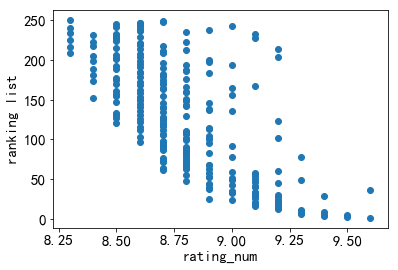

In [38]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.family'] = 'SimHei' #配置中文字体
matplotlib.rcParams['font.size'] = 15   # 更改默认字体大小  
plt.scatter(df['rating_num'], df['num']) #绘制散点图
plt.xlabel('rating_num')    #x轴标签
plt.ylabel('ranking list')  #y轴标签

Text(0.5,0,'rating_num')

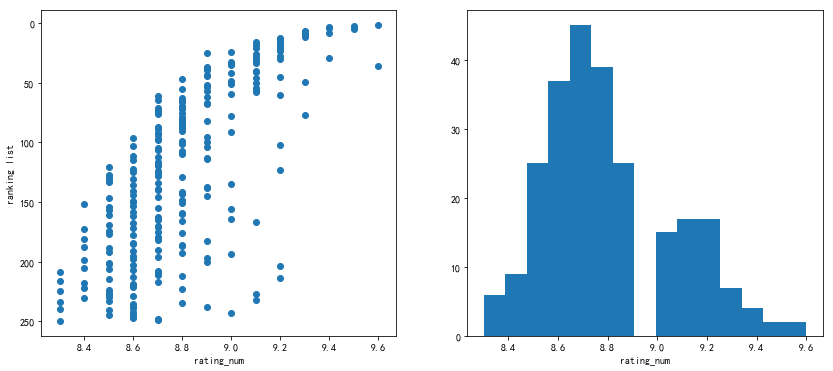

In [39]:
plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1)
plt.scatter(df['rating_num'], df['num'])
plt.xlabel('rating_num')
plt.ylabel('ranking list')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.hist(df['rating_num'],bins = 15)
plt.xlabel('rating_num')

In [40]:
# the relation between ratings and rank-- high negative relation

df['num'].corr(df['rating_num'])

-0.7039109059984314

Text(0.5,0,'comment_num')

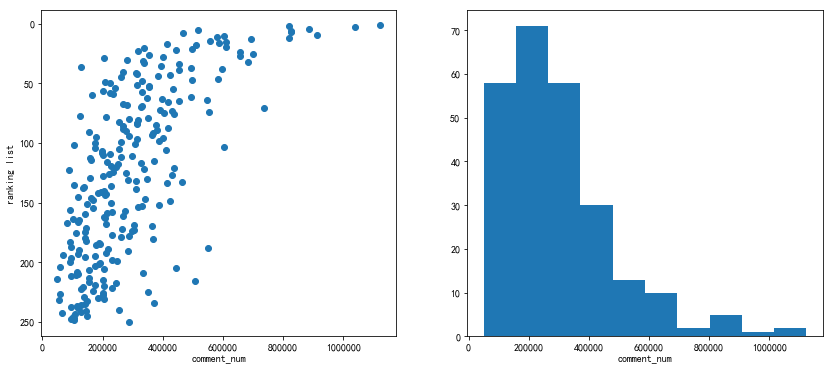

In [41]:
plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1)
plt.scatter(df['comment_num'], df['num'])
plt.xlabel('comment_num')
plt.ylabel('ranking list')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.hist(df['comment_num'])
plt.xlabel('comment_num')

In [49]:
#relation between rank and comment amounts
df['num'].corr(df['comment_num'])

-0.6654951516507418

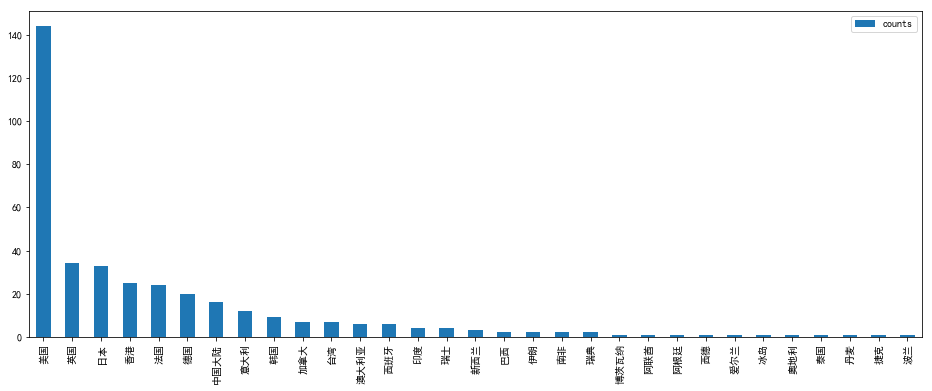

In [42]:
area_c.sort_values(by = 'counts',ascending = False).plot(kind ='bar', figsize = (16,6))

In [43]:
from wordcloud import WordCloud

text = tags_split[['tags_1','tags_2','tags_3','tags_4','tags_5','tags_6','tags_7','tags_8']].to_string(header=False, index=False )
wordcloud = WordCloud(font_path='msyh.ttf',background_color='white',width=5000, height=3000, margin=2).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

NameError: name 'tags_split' is not defined